### Imports

In [3]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load Data

In [4]:
hotelDf = pd.read_csv('reviews.csv')
hotelDf.columns=['filePath','hotelName','reviewColumn','ratingScore','groundTruth']
hotelDf['reviewColumn'] = hotelDf['reviewColumn'].fillna("no")
hotelDf.drop(['filePath'],axis=1,inplace=True)
hotelDf.head(3)

,hotelName,reviewColumn,ratingScore,groundTruth
0,Holiday Inn Express Hotel &amp; Suites Kingston,"""We stayed here just passing through on our wa...",5,positive
1,Holiday Inn Express Hotel &amp; Suites Kingston,"""I travel frequently for business and Kingston...",4,positive
2,Holiday Inn Express Hotel &amp; Suites Kingston,"""We were in town for a sporting event, so we o...",4,positive


### Q1

In [0]:
 def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_vader = sid_obj.polarity_scores(sentence)['compound']
    return sentiment_vader
      

In [6]:
hotelDf['vader'] = hotelDf['reviewColumn'].apply(sentiment_scores)
hotelDf.head()

,hotelName,reviewColumn,ratingScore,groundTruth,vader
0,Holiday Inn Express Hotel &amp; Suites Kingston,"""We stayed here just passing through on our wa...",5,positive,0.9931
1,Holiday Inn Express Hotel &amp; Suites Kingston,"""I travel frequently for business and Kingston...",4,positive,0.9910
2,Holiday Inn Express Hotel &amp; Suites Kingston,"""We were in town for a sporting event, so we o...",4,positive,0.8581
3,Holiday Inn Express Hotel &amp; Suites Kingston,"""My parents had a car accident this weekend ne...",5,positive,-0.5538
4,Holiday Inn Express Hotel &amp; Suites Kingston,"""The room was very nice. Place is clean and m...",5,positive,0.9440


#### (a) Compute average Vader sentiment and average ground truth rating per hotel.

In [7]:
hotel_avgDF = hotelDf.groupby('hotelName')['ratingScore','vader'].mean().reset_index()
hotel_avgDF.head()

,hotelName,ratingScore,vader
0,A Cherry Place Bed and Breakfast,4.950000,0.960145
1,All Suites Whitney Manor,4.858824,0.881452
2,Ambassador Hotel &amp; Conference Centre,3.380000,0.433337
3,Bayside Inn &amp; Waterfront Suites,2.700000,0.249661
4,Best Western Fireside Inn,4.550000,0.849882


#### (b) List ranked hotels

In [0]:
hotelNames = hotel_avgDF['hotelName'].unique()

In [0]:
def getHotelRank(df, measure='ratingScore'):
    #Rank the hotel by ground truth rating score
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pd.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avgRatingScore']
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0)
    return hotelRatingDfGt

In [0]:
hotelRatingDfGt = getHotelRank(hotel_avgDF)
hotelRatingDfVd = getHotelRank(hotel_avgDF, measure='vader')

In [11]:
hotelRatingDfVd.head(5)

,hotelName,avgRatingScore
0,A Cherry Place Bed and Breakfast,0.960145
18,Green Woods Inn,0.959917
34,Secret Garden Bed &amp; Breakfast Inn,0.954265
17,Green Acres Inn,0.926452
40,The Rosemount Inn,0.898553


In [13]:
hotelRatingDfGt.head(5)

,hotelName,avgRatingScore
18,Green Woods Inn,4.962963
0,A Cherry Place Bed and Breakfast,4.950000
1,All Suites Whitney Manor,4.858824
34,Secret Garden Bed &amp; Breakfast Inn,4.762500
17,Green Acres Inn,4.620000


In [12]:
hotelRatingDfVd.tail(5)

,hotelName,avgRatingScore
32,Ramada by Wyndham Kingston Hotel and Conferenc...,0.280141
26,Knights Inn Kingston,0.273062
3,Bayside Inn &amp; Waterfront Suites,0.249661
14,Fort Henry Motel,0.239760
43,Welcome Traveller Motel,0.183920


In [14]:
hotelRatingDfGt.tail(5)

,hotelName,avgRatingScore
26,Knights Inn Kingston,2.886792
3,Bayside Inn &amp; Waterfront Suites,2.700000
43,Welcome Traveller Motel,2.500000
16,General Wolfe Hotel,2.333333
27,Kozy Inn,2.133333


The top 5 and bottom 5 for both ranking methods agree well. Top 5 have 4 same hotels with a little different ranking order. As for the bottom 5 hotels, 3 of them are in both ranking metrics with the same ranking order. 

### Q2. Frequency Analysis

#### (a) term frequency for non-stopwords

In [0]:
def non_stopword(df, label='all',k=50):
  if label=='all':
    reviews = df['reviewColumn'].values
  else:
    reviews = df[df['groundTruth']==label]['reviewColumn'].values
  stop = set(stopwords.words('english'))
  stop.add('hotel')
  stop.add('room')
  stop.add('rooms')
  stop.add('stay')
  stop.add('staff')
  stop.add('kingston')
  # Top-k frequent terms
  counter = Counter()
  tokenizer = RegexpTokenizer(r'\w+')
  lemmatizer = WordNetLemmatizer() 
  stemer=nltk.stem.porter.PorterStemmer()
  for review in reviews:
      words = [i  for i in tokenizer.tokenize(review.lower()) if i not in stop and len(i)>2]
      counter.update(words)
  topk = counter.most_common(k)
  return topk

In [0]:
top50_pos_word=non_stopword(hotelDf,label='positive')
top50_neg_word=non_stopword(hotelDf,label='negative')

In [17]:
print("Top50 frequent words in positive reviews:")
print([word[0] for word in top50_pos_word])
print("Top50 frequent words in negative reviews:")
print([word[0] for word in top50_neg_word])

Top50 frequent words in positive reviews:
['clean', 'breakfast', 'great', 'good', 'nice', 'comfortable', 'friendly', 'would', 'stayed', 'well', 'place', 'one', 'bed', 'inn', 'night', 'area', 'location', 'downtown', 'helpful', 'nthe', 'time', 'parking', 'coffee', 'also', 'back', 'close', 'like', 'quiet', 'motel', 'recommend', 'beds', 'restaurants', 'front', 'service', 'really', 'bathroom', 'everything', 'right', 'lovely', 'little', 'two', 'get', 'could', 'check', 'definitely', 'next', 'excellent', 'pool', 'desk', 'small']
Top50 frequent words in negative reviews:
['would', 'breakfast', 'night', 'one', 'clean', 'good', 'bed', 'could', 'place', 'desk', 'nthe', 'stayed', 'like', 'get', 'front', 'bathroom', 'parking', 'location', 'door', 'back', 'time', 'nice', 'inn', 'two', 'also', 'check', 'small', 'told', 'floor', 'well', 'even', 'coffee', 'friendly', 'great', 'motel', 'old', 'first', 'dirty', 'price', 'comfortable', 'booked', 'beds', 'morning', 'day', 'next', 'water', 'really', 'little'

Both top50 words in positive and negative reviews contain some same nouns such as breakfast, bed, location, etc.

In positive reviews, most adjectives  are positive such as clean, great,comfortable,friendly. Interestingly, some of the frequent adjectives in negative reviews are also positive. It's maybe because these words are negated (e.g."not clean","not good").

#### (b) term frequency for noun phrases

In [0]:
# Noun Phrase Extraction Support Functions
# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = nltk.stem.porter.PorterStemmer().stem(word)
    word = nltk.WordNetLemmatizer().lemmatize(word)
    return word
# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords.words('english'))
    return accepted
# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w)]
        # Phrase only
        if len(term)>1:
            yield term
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [0]:
def NP_topk(df, label='all',k=50):
  if label=='all':  
    reviews = df['reviewColumn'].values
  else:
    reviews = df[df['groundTruth']==label]['reviewColumn'].values
  grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    # Create phrase tree
  chunker = nltk.RegexpParser(grammar)
  tagger = PerceptronTagger()
  pos_tag = tagger.tag
  tokenizer = RegexpTokenizer(r'\w+')
  # Top-k frequent terms
  counter = Counter()
  for review in reviews:
          counter.update(flatten([word
                          for word 
                          in get_terms(chunker.parse(pos_tag(tokenizer.tokenize(review)))) 
                          ]))
  topk = counter.most_common(k) 
  return topk

In [0]:
top50_pos_NP = NP_topk(hotelDf,label='positive')
top50_neg_NP = NP_topk(hotelDf,label='negative')

In [21]:
print("Top50 frequent noun phrases in positive reviews:")
print([word[0] for word in top50_pos_NP])
print("\nTop50 frequent noun phrases in negative reviews:")
print([word[0] for word in top50_neg_NP])

Top50 frequent noun phrases in positive reviews:
['front desk', 'downtown kingston', 'comfort bed', 'great place', 'night stay', 'friendli staff', 'front desk staff', 'kingston area', 'minut drive', 'nthe room', 'great locat', 'good valu', 'next time', 'hot tub', 'clean room', 'secret garden', 'hotel room', 'great stay', 'coffe maker', 'nice touch', 'tim horton', 'free breakfast', 'whitney manor', 'nice place', 'short walk', 'park lot', 'good night', 'first time', 'queen univers', 'comfort inn', 'good locat', 'next door', 'next morn', 'nice hotel', 'queen bed', 'nthe staff', 'short drive', 'continent breakfast', 'minut walk', 'great restaur', 'small fridg', 'lake ontario', 'hochelaga inn', 'easi access', 'comfort room', 'downtown area', 'great valu', 'great view', 'green acr inn', 'great hotel']

Top50 frequent noun phrases in negative reviews:
['front desk', 'comfort inn', 'credit card', 'park lot', 'holiday inn', 'first night', 'queen bed', 'great locat', 'front desk staff', 'hot tub

Similarly, frequent noun phrase in positive reviews includes most of postive words, like comfort bed, friendli staff, and locate-specific phrase like short walk, great locat, downtown kingston.

From the negative reives, some complaints can be concluded since it contains most of facility phrases such as air condition, bathroom door, mini fridg...

### Q3. Mutual Information

In [0]:
def comprehensiveDf(df, topK,mode):
    reviews = df['reviewColumn'].values
    tokenizer = RegexpTokenizer(r'\w+')
    freqReview = []
    if mode == 'word':
        for review in reviews:
            tempCounter = Counter([word.lower() for word in tokenizer.tokenize(review)])
            topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topK]
            freqReview.append(topkinReview)
    elif mode=='phrase':
        grammar = r"""
            NBAR:
                {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
            NP:
                {<NBAR>}
                {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
        """
        chunker = nltk.RegexpParser(grammar)
        tagger = PerceptronTagger()
        pos_tag = tagger.tag
        for review in reviews:
            tempCounter = Counter(flatten([word 
                                           for word 
                                           in get_terms(chunker.parse(pos_tag(tokenizer.tokenize(review))))]))
            topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topK]
            freqReview.append(topkinReview)
            
    #Find out if a particular review has the word from topk list
    for review in reviews:
        tempCounter = Counter([word for word in tokenizer.tokenize(review.lower())])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topK]
        freqReview.append(topkinReview)

    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []

    freqReviewDf.columns = [c[0] for c in topK]
    finalreviewDf = df.join(freqReviewDf)
    return finalreviewDf

In [0]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

#### (a) Mutual Information(Word)

In [0]:
topk_word=non_stopword(hotelDf,label='all')
finaldf = comprehensiveDf(hotelDf,topk_word,mode='word')
miScoredf = getMI(topk_word, finaldf)

In [55]:
miScoredf.head(50)

,Word,MI Score
4,great,0.022961
7,comfortable,0.019327
0,clean,0.015937
48,door,0.014776
29,downtown,0.013517
10,friendly,0.012464
21,could,0.011975
32,helpful,0.010858
47,quiet,0.009458
9,night,0.009065


The list contains both postive and negative reviews, so it is hard to determine the noun is a complaint or a praise. The adjectives are mostly postive.

#### (b) Mutual Information(Noun Phrase)

In [57]:
topk_np=NP_topk(hotelDf,label='all')
finaldf_np = comprehensiveDf(hotelDf,topk_np,mode='phrase')
miScoredf_np = getMI(topk_np, finaldf_np)
miScoredf_np.head(50)

,Word,MI Score
0,front desk,0.007252
23,credit card,0.005241
29,first night,0.003853
17,holiday inn,0.002498
2,downtown kingston,0.002176
14,friendli staff,0.002154
1,comfort inn,0.002137
6,park lot,0.001988
38,great stay,0.001982
11,great place,0.001922


We can see that no matter the review is positive or negative , most tourists care about the front desk service most.

### Q4. Pointwise Mutual Information

In [0]:
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            px = (sum(df['groundTruth']==i))/(len(df))
            py = (sum(df[x]==j))/(len(df))
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0: # Log 0 cannot happen
                if px*py==0:
                    pmi = math.log((pxy+0.0001)/(px*py+0.00001))
                else:
                    pmi = math.log((pxy+0.0001)/(px*py))
            else:
                pmi = math.log(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pd.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

def pmiIndivCal(df, x, gt, label_column='groundTruth'):
    px = (sum(df[label_column]==gt))/(len(df))
    py = (sum(df[x]==1))/(len(df))
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)

    if pxy==0: #Log 0 cannot happen
        if px*py==0:
            pmi = math.log((pxy+0.0001)/(px*py+0.00001))
        else:
            pmi = math.log((pxy+0.0001)/(px*py))
    else:
        pmi = math.log(pxy/(px*py))
    return pmi
  
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pd.DataFrame(pmilist)
    pmiposlist = pd.DataFrame(pmiposlist)
    pmineglist = pd.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

#### (a) Pointwise Mutual Information (Word)

In [162]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf,topk_word)

100%|██████████| 50/50 [00:00<00:00, 60.02it/s]


In [163]:
#Sorted top pmi words for positive reviews
pmiposlist.sort_values('pmi',ascending=0).head(5)

,word,pmi
29,downtown,0.224852
47,quiet,0.221746
49,restaurants,0.217873
32,helpful,0.205863
4,great,0.202775


In [164]:
#Sorted top pmi words for negative reviews
pmineglist.sort_values('pmi',ascending=0).head(5)

,word,pmi
48,door,0.603965
21,could,0.440010
25,get,0.376872
26,desk,0.373562
46,even,0.337345


Top positive rankings tell us the location is very important. Tourists like downtown hotels, and with quiet environment, good restaurants.

From top negative rankings we can see that most complaints are 
about facilities like door.

#### (b) Pointwise Mutual Information (Phrase)

In [165]:
pmiposlist_np, pmineglist_np, pmidf_np = pmiForAllCal(finaldf_np,topk_np)

100%|██████████| 50/50 [00:00<00:00, 63.95it/s]


In [166]:
pmiposlist_np.sort_values('pmi',ascending=0).head(10)

,word,pmi
38,great stay,0.341763
43,whitney manor,0.338133
35,secret garden,0.333795
34,nice touch,0.302542
14,friendli staff,0.302542
21,kingston area,0.292973
22,minut drive,0.290212
11,great place,0.282502
2,downtown kingston,0.267072
4,comfort bed,0.257422


In [167]:
pmineglist_np.sort_values('pmi',ascending=0).head(10)

,word,pmi
23,credit card,1.012474
29,first night,0.869752
17,holiday inn,0.724792
46,next day,0.694020
41,air condition,0.676002
48,breakfast room,0.666432
45,mini fridg,0.607009
42,ground floor,0.607009
1,comfort inn,0.591694
6,park lot,0.570641


Top positive rankings tell us that people like hotels that located in downtown and have friendly staff.

The top negative noun phrase is credit card. People may complain about the hotel when they have issue paying with credit card. And hotels with negative reivews often have facility problems(e.g. air condition not working). 

#### (c) Repeat this analysis for the single top and single bottom hotel (according to the ground truth rating).

In [0]:
top_hotel = hotelRatingDfGt['hotelName'][:10].values
bot_hotel = hotelRatingDfGt['hotelName'][-5:].values

In [191]:
print('top hotel:',top_hotel[6])
print('bottom hotel:', bot_hotel[1])

top hotel: Best Western Fireside Inn
bottom hotel: Bayside Inn &amp; Waterfront Suites


In [0]:
hotel_topdf=hotelDf[hotelDf['hotelName']==top_hotel[6]].reset_index()
hotel_botdf=hotelDf[hotelDf['hotelName']==bot_hotel[1]].reset_index()

topk_word_top=non_stopword(hotel_topdf,label='all')
finaldf_top= comprehensiveDf(hotel_topdf,topk_word_top,mode='word')
topk_word_topNP=NP_topk(hotel_topdf,label='all')
finaldf_topNP= comprehensiveDf(hotel_topdf,topk_word_topNP,mode='phrase')

topk_word_bot=non_stopword(hotel_botdf,label='all')
finaldf_bot= comprehensiveDf(hotel_botdf,topk_word_bot,mode='word')
topk_word_botNP=NP_topk(hotel_botdf,label='all')
finaldf_botNP= comprehensiveDf(hotel_botdf,topk_word_botNP,mode='phrase')

In [192]:
pmiposlist_top, pmineglist_top, pmidf_top = pmiForAllCal(finaldf_top,topk_word_top)
pmiposlist_bot, pmineglist_bot, pmidf_bot = pmiForAllCal(finaldf_bot,topk_word_bot)

pmiposlist_topPhrase, pmineglist_topPhrase, pmidf_topPhrase = pmiForAllCal(finaldf_topNP,topk_word_topNP)
pmiposlist_botPhrase, pmineglist_botPhrase, pmidf_botPhrase = pmiForAllCal(finaldf_botNP,topk_word_botNP)

100%|██████████| 50/50 [00:00<00:00, 92.62it/s]


In [193]:
pmiposlist_topPhrase.sort_values('pmi',ascending=0).head(5)

,word,pmi
0,best western firesid inn,0.072571
22,fire place,0.072571
24,stuf anim,0.072571
26,night stay,0.072571
27,stori hotel,0.072571


In [194]:
pmineglist_topPhrase.sort_values('pmi',ascending=0).head(5)

,word,pmi
29,unpleas experi femal worker,2.659260
44,nice experi,2.659260
5,breakfast room,2.253795
33,great breakfast,1.966113
34,hotel staff,1.966113


In [195]:
pmiposlist_botPhrase.sort_values('pmi',ascending=0).head(5)

,word,pmi
41,conveni locat,1.014731
20,good stay,1.014731
18,standard room,1.014731
21,nice ladi,1.014731
16,friendli staff,1.014731


In [196]:
pmineglist_botPhrase.sort_values('pmi',ascending=0).head(5)

,word,pmi
0,doubl bed,0.450201
24,mani hotel,0.450201
48,guy cur,0.450201
40,extra child,0.450201
39,previou guest,0.450201


From reviews of the top hotel Best Western Fireside Inn, we can see that people like its fire place and complain about the unpleasant hotel workers. 

For the bottom hotel Bayside Inn & Waterfront Suites, people like its convenient location and friendly staff but complain about its facility like double bed, and maybe the bed is not tidy after previous guest leaving. 

### Q5. General Plots

#### (a) Histogram

In [0]:
def getHistogram(compdf, measure, title):
    if measure=='both':
        x = [compdf['ratingScore'].values/5]
        y = [compdf['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='x')
        plt.hist(y, bins, label='y')
        plt.legend(loc='upper right')
        plt.show()
    
    else:
        plt.hist(compdf[measure].values)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        fig = plt.gcf()

##### (a) Show separate histograms of ground truth and Vader sentiment scores (ignore hotel ID).

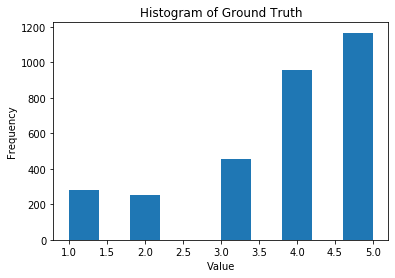

In [40]:
# (a) Show separate histograms of ground truth and Vader sentiment scores (ignore hotel ID).
getHistogram(hotelDf,'ratingScore', 'Histogram of Ground Truth')

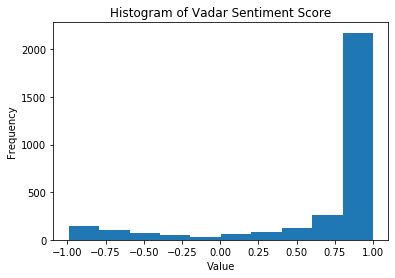

In [41]:
getHistogram(hotelDf, 'vader', 'Histogram of Vadar Sentiment Score')

Both hisograms have more reviews on positive ratings. People are more likely to write a review about the hotel when they like this hotel.

##### (b) Show a histogram of the number of reviews per hotel

Text(0.5, 1.0, 'Distribution of the Reviews over All Hotels')

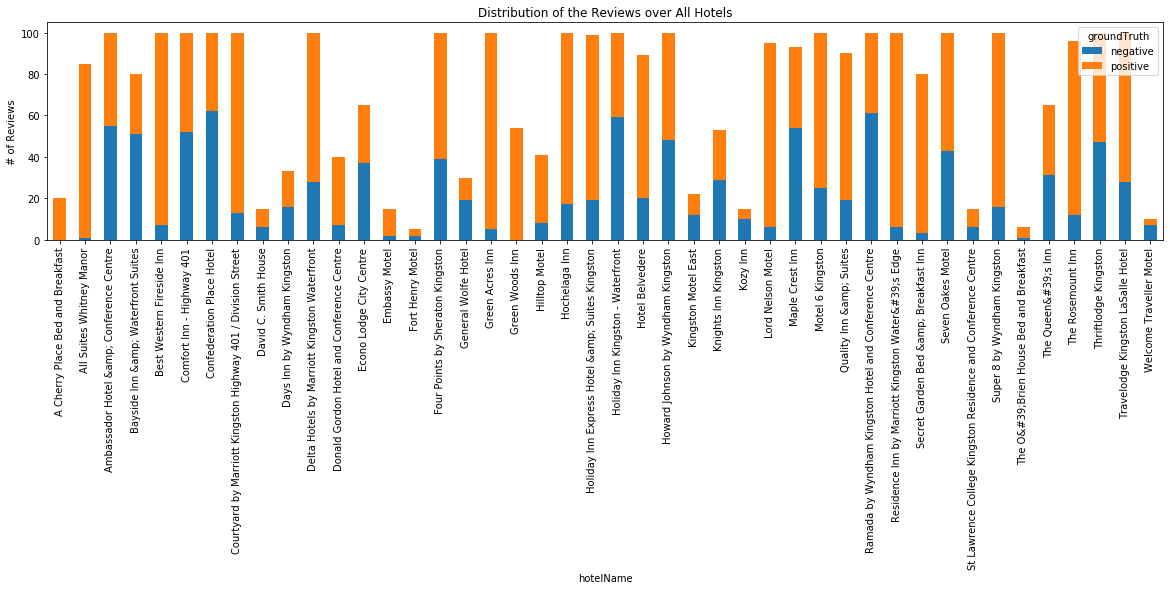

In [42]:
review_hotel=hotelDf.groupby(['hotelName', 'groundTruth']).size().unstack('groundTruth').fillna(0)
review_hotel.plot(kind='bar', stacked=True,figsize=(20,4))

plt.ylabel('# of Reviews')
plt.title('Distribution of the Reviews over All Hotels')

Most hotels that have more than 60 reviews have more positive reviews than negative reviews.

#### (b) Boxplots

##### (a) 5 side-by-side boxplots for top-5 hotels

In [0]:
# review_num=hotelDf.groupby(['hotelName'])['vader'].count().rename('count').reset_index()
# review_num.sort_values('count',ascending=0)

In [159]:
tp5gthotel = hotelRatingDfGt['hotelName'][:5].values
tp5gthotel

array(['Green Woods Inn', 'A Cherry Place Bed and Breakfast',
       'All Suites Whitney Manor',
       'Secret Garden Bed &amp; Breakfast Inn', 'Green Acres Inn'],
      dtype=object)

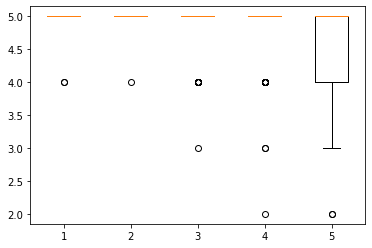

In [44]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel


greeenwood = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel[0]]['ratingScore']
cherryplace = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel[1]]['ratingScore']
whitneymanor = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel[2]]['ratingScore']
secretgarden = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel[3]]['ratingScore']
greenacres = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel[4]]['ratingScore']

data = [greeenwood, cherryplace, whitneymanor, secretgarden, greenacres]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

In [45]:
tp5gthotel_vd = hotelRatingDfVd['hotelName'][:5].values
tp5gthotel_vd

array(['A Cherry Place Bed and Breakfast', 'Green Woods Inn',
       'Secret Garden Bed &amp; Breakfast Inn', 'Green Acres Inn',
       'The Rosemount Inn'], dtype=object)

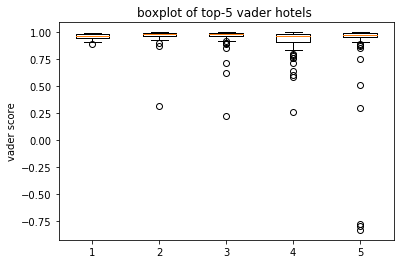

In [46]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel


cherryplace = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel_vd[0]]['vader']
greeenwood = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel_vd[1]]['vader']
secretgarden = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel_vd[2]]['vader']
greenacres = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel_vd[3]]['vader']
rosemount = hotelDf.loc[hotelDf['hotelName'] == tp5gthotel_vd[4]]['vader']

data = [ cherryplace,greeenwood,  secretgarden, greenacres,rosemount ]
# multiple box plots on one figure
plt.figure()
plt.title('boxplot of top-5 vader hotels ')
plt.ylabel('vader score')
plt.boxplot(data)
plt.show()

##### (b) Report the mean and variance of the ground truth and Vader sentiment scores for the top-5 ranked hotels according to star rating.

In [47]:
# (b) The mean and variance of the ground truth for the top-5 ranked hotels according to star rating.
hotelReview_top5DF = hotelDf[hotelDf['hotelName'].isin(tp5gthotel.tolist())]
hotelReview_top5DF.groupby('hotelName').mean()[['ratingScore','vader']].sort_values('ratingScore',ascending=0)

,ratingScore,vader
hotelName,,
Green Woods Inn,4.962963,0.959917
A Cherry Place Bed and Breakfast,4.950000,0.960145
All Suites Whitney Manor,4.858824,0.881452
Secret Garden Bed &amp; Breakfast Inn,4.762500,0.954265
Green Acres Inn,4.620000,0.926452


In [48]:
hotelReview_top5DF.groupby('hotelName').std()[['ratingScore','vader']].sort_values('ratingScore',ascending=1)

,ratingScore,vader
hotelName,,
Green Woods Inn,0.190626,0.092512
A Cherry Place Bed and Breakfast,0.223607,0.029599
All Suites Whitney Manor,0.382751,0.166969
Secret Garden Bed &amp; Breakfast Inn,0.556748,0.099864
Green Acres Inn,0.647918,0.107320


##### (c) 

Boxplot makes more sense since it excludes the outliers while variance consider outlier. Outliers may have large effect to the mean since the sample is small.

#### (c) Scatterplots and heatmaps

##### (a) Show the scatterplot of ground truth score (star rating) versus Vader sentiment score.

Text(0.5, 0, 'Vader Score')

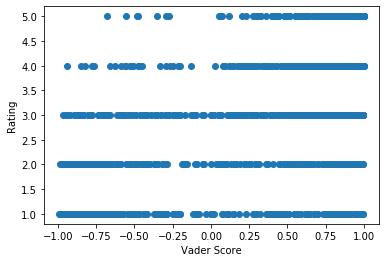

In [49]:
# (a) Show the scatterplot of ground truth score (star rating) versus Vader sentiment score.
y = hotelDf['ratingScore'].values
x = hotelDf['vader'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Vader Score')

Text(0, 0.5, 'Rating')

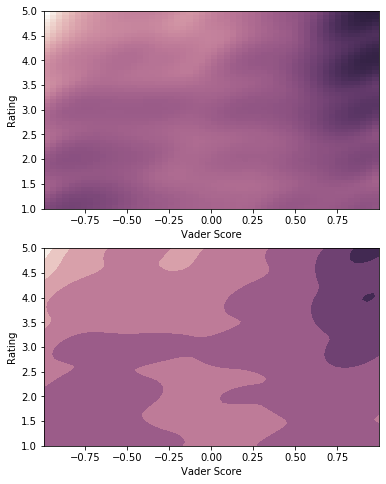

In [50]:
# Show the heatmap of ground truth score (star rating) versus Vader sentiment score.

from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

High rating(4-5) most likely corresponds to postive comment(the drak area on the top right). And we can see that with rating lower than 3.5, half of the comments are not nice while others are comparatively acceptable.


##### (b) Show scatterplots of the length of reviews versus each of ground truth score and Vader sentiment score.

In [0]:
hotelDf['reviewLength'] = hotelDf['reviewColumn'].apply(lambda x:len(x.split()))

Text(0.5, 0, 'Review Length')

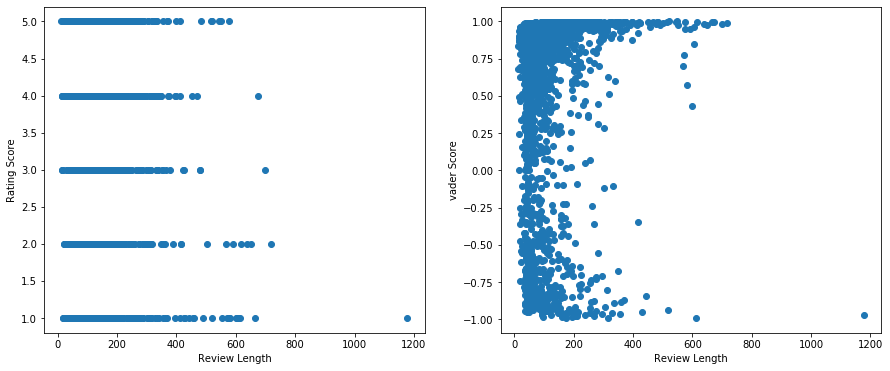

In [160]:
y = hotelDf['reviewLength'].values
x1 = hotelDf['ratingScore'].values
x2 = hotelDf['vader'].values

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot( y,x1,"o")
ax2.plot( y,x2,"o")

ax1.set_ylabel('Rating Score')
ax1.set_xlabel('Review Length')

ax2.set_ylabel('vader Score')
ax2.set_xlabel('Review Length')

Text(0, 0.5, 'Vader Score')

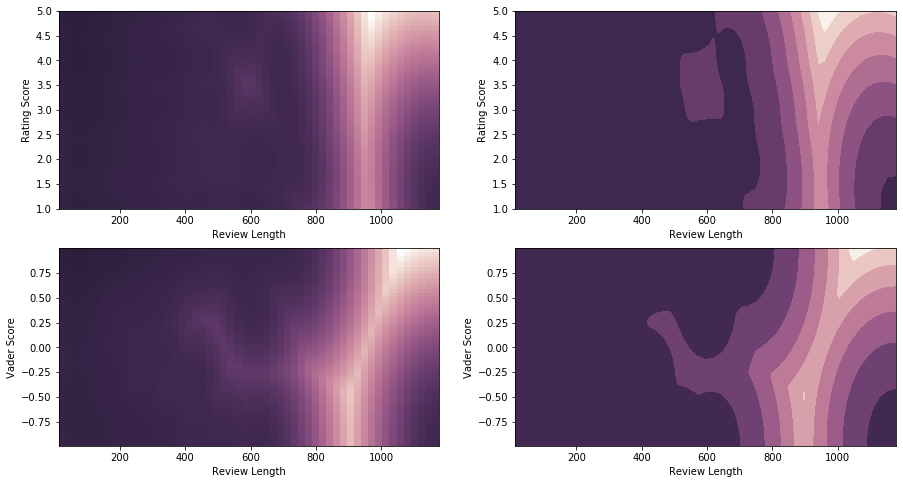

In [53]:
x = hotelDf['reviewLength'].values
y_vr = hotelDf['vader'].values
y=hotelDf['ratingScore'].values

kv = gaussian_kde(np.vstack([x, y_vr]))
xiv, yiv = np.mgrid[x.min():x.max():x.size**0.5*1j,y_vr.min():y_vr.max():y_vr.size**0.5*1j]
ziv = kv(np.vstack([xiv.flatten(), yiv.flatten()]))

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax3.pcolormesh(xiv, yiv, np.log10(ziv.reshape(xiv.shape)), cmap=cmap)
ax4.contourf(xiv, yiv, np.log10(ziv.reshape(xiv.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())
ax3.set_xlim(x.min(), x.max())
ax3.set_ylim(y_vr.min(), y_vr.max())
ax4.set_xlim(x.min(), x.max())
ax4.set_ylim(y_vr.min(), y_vr.max())

ax1.set_xlabel('Review Length')
ax1.set_ylabel('Rating Score')

ax2.set_xlabel('Review Length')
ax2.set_ylabel('Rating Score')

ax3.set_xlabel('Review Length')
ax3.set_ylabel('Vader Score')

ax4.set_xlabel('Review Length')
ax4.set_ylabel('Vader Score')

The scatter and heatmaps indicate that most positive and negative reviews are tend to have short review length. Some extremely negative reviews have very long review length.
 

##### (c) Show two scatterplots of the number of reviews per hotel versus each of average ground truth score and average Vader sentiment score.

Text(0.5, 0, '# of Reviews')

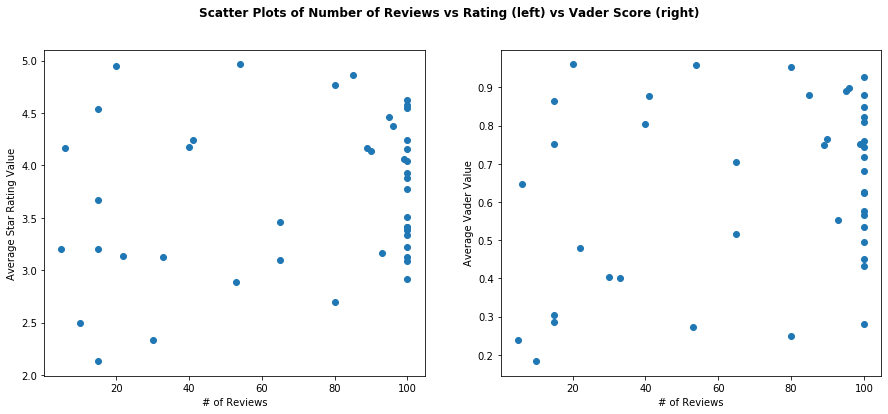

In [54]:
review_count = hotelDf.groupby('hotelName').size().tolist()

x = np.array(review_count)
y = hotelRatingDfGt.sort_values('hotelName',ascending=1)['avgRatingScore'].values
y_v = hotelRatingDfVd.sort_values('hotelName',ascending=1)['avgRatingScore'].values


fig = plt.figure(figsize=(15,6))
plt.suptitle('Scatter Plots of Number of Reviews vs Rating (left) vs Vader Score (right)', fontweight='bold')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(x, y,"o")
ax1.set_ylabel('Average Star Rating Value')
ax1.set_xlabel('# of Reviews')

ax2.plot(x, y_v,"o")
ax2.set_ylabel('Average Vader Value')
ax2.set_xlabel('# of Reviews')

It's hardly to see any trends from these two images. Some of the hotels with most reviews have positive reviews, others have negative reviews.